# CombineData

This notebook takes all of the data outputs from the various GetData notebooks, cleans and combines them into a single dataframe, and performs some initial exploratory data analysis.

In [1]:
%matplotlib inline

from bs4 import BeautifulSoup
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import string
import requests
import time

/Users/gkafka/anaconda/envs/insight/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Pull the dictionaries from the json files, convert them to dataframes, and set the index to an integer type.

In [2]:
with open('DataRehabCenters.json', 'r') as f:
    rehab_dict = json.load(f);
with open('DataMortality.json', 'r') as f:
    mortality_dict = json.load(f);
with open('DataPrescriptionMedicare.json', 'r') as f:
    prescription_dict = json.load(f);

rehab_df = pd.DataFrame(rehab_dict);

mortality_df = pd.DataFrame(mortality_dict);
mortality_df.index = mortality_df.index.astype(int);
mortality_df.sort_index(inplace=True);

prescription_df = pd.DataFrame(prescription_dict);
prescription_df.index = prescription_df.index.astype(int);
prescription_df.sort_index(inplace=True);

Set consistent labels! Print the data types of the columns to scan for potential issues. Many of the mortality dataframe objects should be integers, but are just strings.

In [3]:
rename_dict = {'state':'ST', 'county':'County'};
rehab_df.rename(columns=rename_dict, inplace=True);

print "Rehab df types:"
print rehab_df.dtypes
print "\nMortality df types:"
print mortality_df.dtypes
print "\nPrescription df types:"
print prescription_df.dtypes

Rehab df types:
County          object
n_facilities     int64
ST              object
dtype: object

Mortality df types:
County                                                          object
Estimated Age-adjusted Death Rate, 11 Categories (in ranges)    object
FIPS                                                            object
FIPS State                                                      object
Population                                                      object
ST                                                              object
State                                                           object
Year                                                            object
dtype: object

Prescription df types:
County                      object
FIPS                         int64
FIPS State                   int64
Opioid Claims              float64
Opioid Prescribing Rate    float64
Overall Claims             float64
Part D Prescribers         float64
ST                          o

Set the FIPS, FIPS State, Population, and Year columns as integer type for the mortality dict. This requires first replacing NaNs as some value, and resetting the values to NaN after the conversion. (This actually promotes the data type from integer to float, but since the real desire is for a numerical type, this is fine.)

In [4]:
mortality_df.fillna('-1', inplace=True);

mortality_df['FIPS'] = mortality_df['FIPS'].astype(int);
mortality_df['FIPS State'] = mortality_df['FIPS State'].astype(int);
mortality_df['Population'] = mortality_df['Population'].astype(int);
mortality_df['Year'] = mortality_df['Year'].astype(int);

mortality_df.replace({'Population': {-1:np.nan}}, inplace=True);

mortality_df.head()

,County,"Estimated Age-adjusted Death Rate, 11 Categories (in ranges)",FIPS,FIPS State,Population,ST,State,Year
0,"Autauga County, AL",2.1-4,1001,1,42963,AL,Alabama,1999
1,"Autauga County, AL",4.1-6,1001,1,44021,AL,Alabama,2000
2,"Autauga County, AL",4.1-6,1001,1,44889,AL,Alabama,2001
3,"Autauga County, AL",4.1-6,1001,1,45909,AL,Alabama,2002
4,"Autauga County, AL",4.1-6,1001,1,46800,AL,Alabama,2003


Add a new column that converts "Estimated Age-adjusted Death Rate" to a numerical type. Pull a list of all possible values of the original columns by grouping the dataframe (e.g., 2.1-4 or >20), split the string on punctuation, take the last word (e.g., 4 or 20), and add one for the case of '>20', otherwise subtract 1.

In [5]:
grouped_df = mortality_df.groupby('Estimated Age-adjusted Death Rate, 11 Categories (in ranges)');

death_rate_map = {};
death_rate_list = grouped_df.groups.keys();
for rate in death_rate_list:
    if('>' in rate):
        death_rate_map[rate] = int(rate.split('>')[-1])+1;
    else:
        death_rate_map[rate] = int(rate.split('-')[-1])-1;

mortality_df['Death Rate Category Median'] = [death_rate_map[rate] for rate in
    mortality_df['Estimated Age-adjusted Death Rate, 11 Categories (in ranges)'].values];
mortality_df.head()

,County,"Estimated Age-adjusted Death Rate, 11 Categories (in ranges)",FIPS,FIPS State,Population,ST,State,Year,Death Rate Category Median
0,"Autauga County, AL",2.1-4,1001,1,42963,AL,Alabama,1999,3
1,"Autauga County, AL",4.1-6,1001,1,44021,AL,Alabama,2000,5
2,"Autauga County, AL",4.1-6,1001,1,44889,AL,Alabama,2001,5
3,"Autauga County, AL",4.1-6,1001,1,45909,AL,Alabama,2002,5
4,"Autauga County, AL",4.1-6,1001,1,46800,AL,Alabama,2003,5


In order to join the datasets, the county names need to be as good a match as possible. The common errors are when the county is listed as a parish or borough, and how the word 'saint' is written (i.e., Saint, St, or St.). This function makes everything lower case, calls everything a county, and sets all versions of 'saint' to 'saint'.

In [6]:
def fix_county(word):
    new_word = word.lower().replace('.', '');
    new_word = new_word.replace('saint','st');
    new_word = new_word.split(',')[0]
    if ('county' in new_word) and ('parish' in new_word):
        new_word = new_word.replace(' parish','');
    if ('county' in new_word) and ('borough' in new_word):
        new_word = new_word.replace(' borough','');
    if 'parish' in new_word:
        new_word = new_word.replace('parish','county');
    if 'borough' in new_word:
        new_word = new_word.replace('borough','county');
    if 'county' not in new_word:
        new_word = ' '.join([new_word, 'county']);
    return new_word

Use the above function to standardize the county names. Manually fix the outstanding issues.

In [7]:
rehab_df['County']        = rehab_df['County'].apply(fix_county);
mortality_df['County']    = mortality_df['County'].apply(fix_county);
prescription_df['County'] = prescription_df['County'].apply(fix_county);

rehab_df.set_value(183,  'County', "prince george's county");
rehab_df.set_value(299,  'County', 'la porte county');
rehab_df.set_value(667,  'County', 'kauai county');
rehab_df.set_value(1068, 'County', "anchorage county");
rehab_df.set_value(1117, 'County', "queen anne's county");
mortality_df.set_value(10288, 'County', "lasalle county");
mortality_df.set_value(36525, 'County', "mckean county");

Merge all of the datasets!

Merge the mortality and prescription dataframes on several columns that should match. There are several outstanding mismatches in the county names between these dataframes that almost entirely encompass city/county entities that are inconsistently labeled. The remaining mismatches are from the 'unorganized borough' of Alaska, which will be dropped later. Thus, the county is not used as a key, and the county column from the prescription dataframe is dropped.

The rehab dataframe is merged with the result without special considerations.

In [8]:
df = pd.merge(mortality_df, prescription_df, on=['FIPS', 'FIPS State', 'ST', 'State', 'Year'], how='outer');
df.drop('County_y', axis=1, inplace=True);
df.rename(columns={'County_x':'County'}, inplace=True);
df = pd.merge(df, rehab_df, on=['County', 'ST'], how='outer');
print df.shape;
df.head()

(50261, 14)


,County,"Estimated Age-adjusted Death Rate, 11 Categories (in ranges)",FIPS,FIPS State,Population,ST,State,Year,Death Rate Category Median,Opioid Claims,Opioid Prescribing Rate,Overall Claims,Part D Prescribers,n_facilities
0,autauga county,2.1-4,1001,1,42963,AL,Alabama,1999,3,NaN,NaN,NaN,NaN,NaN
1,autauga county,4.1-6,1001,1,44021,AL,Alabama,2000,5,NaN,NaN,NaN,NaN,NaN
2,autauga county,4.1-6,1001,1,44889,AL,Alabama,2001,5,NaN,NaN,NaN,NaN,NaN
3,autauga county,4.1-6,1001,1,45909,AL,Alabama,2002,5,NaN,NaN,NaN,NaN,NaN
4,autauga county,4.1-6,1001,1,46800,AL,Alabama,2003,5,NaN,NaN,NaN,NaN,NaN


In order to use data where all fields are present, only keep records from 2013 and 2014. Fill the missing values for the number of facilities with 0, since there were no facilities found when scraping for these counties.

Show the remaining values with missing data. These are largely from unconsistently labeled versions of Alaska's unorganized borough. The remaining minority of rows with missing data come randomly from different states. However, they represent less than 2.5% of the total number of counties, so it is not egregious to simply drop these rows. There are still 3073 of 3144 (from Wikipedia) county like entities that remain. The resultant dataframe has no missing data and is ready for modeling!

In [9]:
df = df[df['Year'] > 2012]
df['n_facilities'].fillna(0, inplace=True)
print df.shape
nullmask = pd.isnull(df)
print np.sum(nullmask)
print len(df[pd.isnull(df['Overall Claims'])].groupby('County').groups.keys())
df.dropna(inplace=True);
print df.shape
print len(df.groupby(['County','ST']).groups.keys())

(6291, 14)
County                                                           10
Estimated Age-adjusted Death Rate, 11 Categories (in ranges)     10
FIPS                                                              0
FIPS State                                                        0
Population                                                       17
ST                                                                0
State                                                             0
Year                                                              0
Death Rate Category Median                                       10
Opioid Claims                                                   144
Opioid Prescribing Rate                                         144
Overall Claims                                                  144
Part D Prescribers                                              144
n_facilities                                                      0
dtype: int64
74
(6137, 14)
3073


Save the cleaned, combined dataframe, test that it loads properly, and perform a little exploratory data analysis!

In [10]:
df.to_json("DataCombined.json");

In [2]:
with open('DataCombined.json', 'r') as f:
    d = json.load(f);

df = pd.DataFrame(d);
df.index = df.index.astype(int);
df.sort_index(inplace=True);
df.head()

,County,Death Rate Category Median,"Estimated Age-adjusted Death Rate, 11 Categories (in ranges)",FIPS,FIPS State,Opioid Claims,Opioid Prescribing Rate,Overall Claims,Part D Prescribers,Population,ST,State,Year,n_facilities
14,autauga county,11.0,10.1-12,1001.0,1.0,20482.0,9.803002,208936.0,67.0,55136.0,AL,Alabama,2013.0,0.0
15,autauga county,11.0,10.1-12,1001.0,1.0,20355.0,9.724810,209310.0,67.0,55395.0,AL,Alabama,2014.0,0.0
30,baldwin county,19.0,18.1-20,1003.0,1.0,82517.0,9.151229,901704.0,407.0,195443.0,AL,Alabama,2013.0,16.0
31,baldwin county,19.0,18.1-20,1003.0,1.0,81866.0,9.052919,904305.0,425.0,200111.0,AL,Alabama,2014.0,16.0
46,barbour county,7.0,6.1-8,1005.0,1.0,8935.0,6.278679,142307.0,33.0,26978.0,AL,Alabama,2013.0,0.0


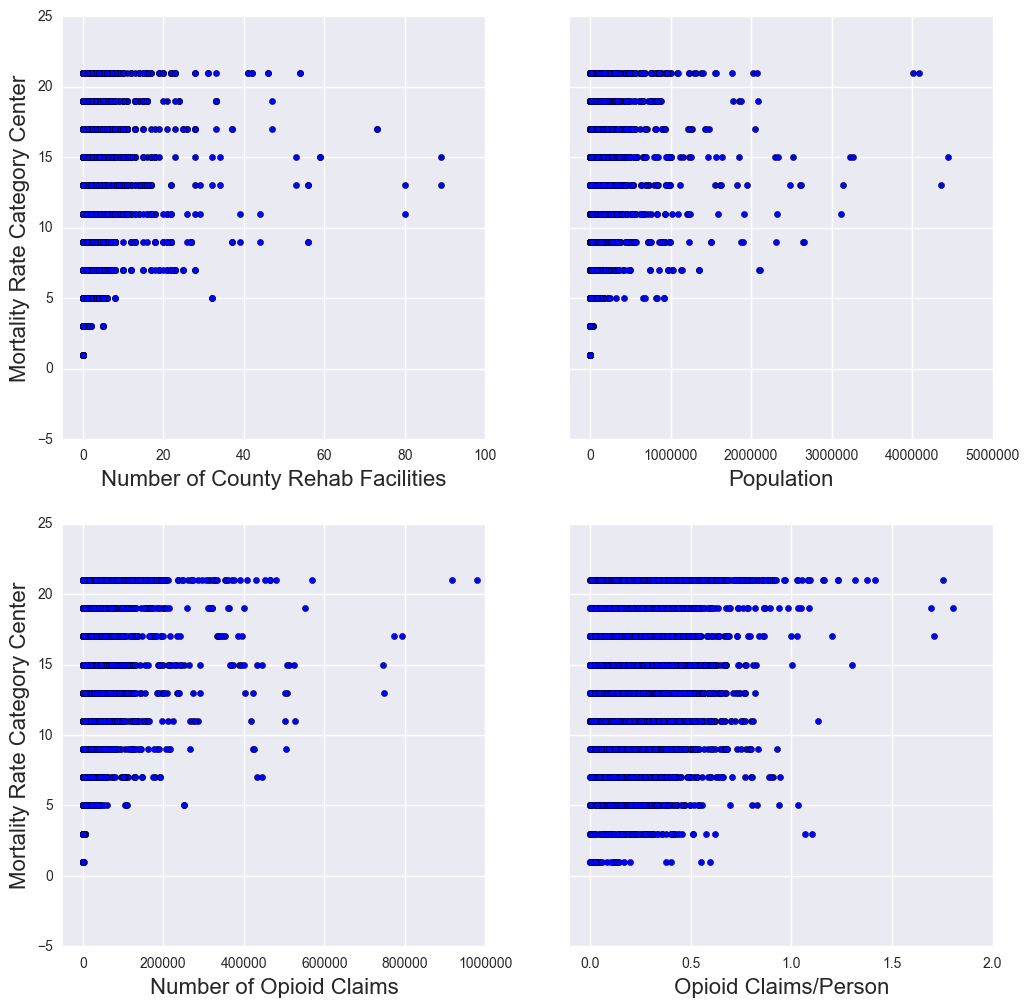

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), sharey=True);

axes[0][0].scatter(df['n_facilities'], df['Death Rate Category Median']);
axes[0][0].set_xlabel('Number of County Rehab Facilities');
axes[0][0].xaxis.label.set_fontsize(16);
axes[0][0].set_xlim(-5,100);
axes[0][0].set_ylabel('Mortality Rate Category Center');
axes[0][0].yaxis.label.set_fontsize(16);

axes[0][1].scatter(df['Population'], df['Death Rate Category Median']);
axes[0][1].set_xlabel('Population');
axes[0][1].xaxis.label.set_fontsize(16);
axes[0][1].set_xlim(-0.025*1e7,0.5*1e7);

axes[1][0].scatter(df['Opioid Claims'], df['Death Rate Category Median']);
axes[1][0].set_xlabel('Number of Opioid Claims');
axes[1][0].xaxis.label.set_fontsize(16);
axes[1][0].set_xlim(-50000,1000000);
axes[1][0].set_ylabel('Mortality Rate Category Center');
axes[1][0].yaxis.label.set_fontsize(16);

axes[1][1].scatter(df['Opioid Claims'].values/df['Population'].values, df['Death Rate Category Median']);
axes[1][1].set_xlabel('Opioid Claims/Person');
axes[1][1].xaxis.label.set_fontsize(16);
axes[1][1].set_xlim(-0.1,2);


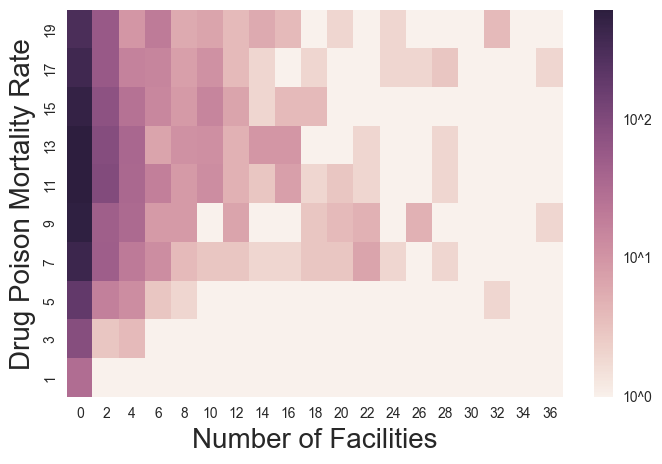

In [78]:
h2d, xe, ye = np.histogram2d(df['n_facilities'], df['Death Rate Category Median'],
                             bins=[xrange(0,40,2), xrange(0,22,2)])
h2d = h2d.transpose()
#ax = sns.heatmap(h2d)
#ax.invert_yaxis()
h2d = np.log10(h2d)
h2d[h2d == -np.inf] = 0

fig = plt.subplots(figsize=(8,5))
ax = sns.heatmap(h2d, xticklabels=range(0,40,2), yticklabels=range(1,21,2))
ax.invert_yaxis()
ax.set_xlabel('Number of Facilities')
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel('Drug Poison Mortality Rate')
ax.yaxis.label.set_fontsize(20)
cbar = ax.collections[0].colorbar
maxval = np.max(h2d)
cbar.set_ticks([x for x in np.arange(0,maxval, 1)])
cbar.set_ticklabels(['10^{0}'.format(int(x)) for x in np.arange(0,maxval, 1)])
plt.savefig('EDA_nfacility.png')

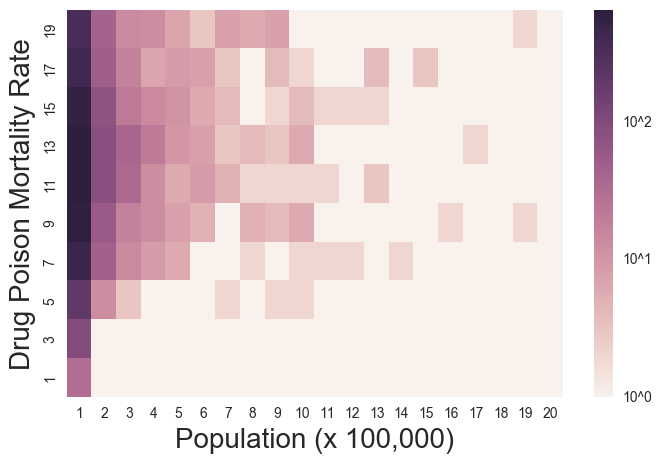

In [77]:
h2d, xe, ye = np.histogram2d(df['Population'], df['Death Rate Category Median'],
                             bins=[xrange(0,2100000,100000), xrange(0,22,2)])
h2d = h2d.transpose()
#ax = sns.heatmap(h2d)
#ax.invert_yaxis()
h2d = np.log10(h2d)
h2d[h2d == -np.inf] = 0

fig = plt.subplots(figsize=(8,5))
ax = sns.heatmap(h2d, xticklabels=range(1,21,1), yticklabels=range(1,21,2))
ax.invert_yaxis()
ax.set_xlabel('Population (x 100,000)')
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel('Drug Poison Mortality Rate')
ax.yaxis.label.set_fontsize(20)
cbar = ax.collections[0].colorbar
maxval = np.max(h2d)
cbar.set_ticks([x for x in np.arange(0,maxval, 1)])
cbar.set_ticklabels(['10^{0}'.format(int(x)) for x in np.arange(0,maxval, 1)])
plt.savefig('EDA_population.png')

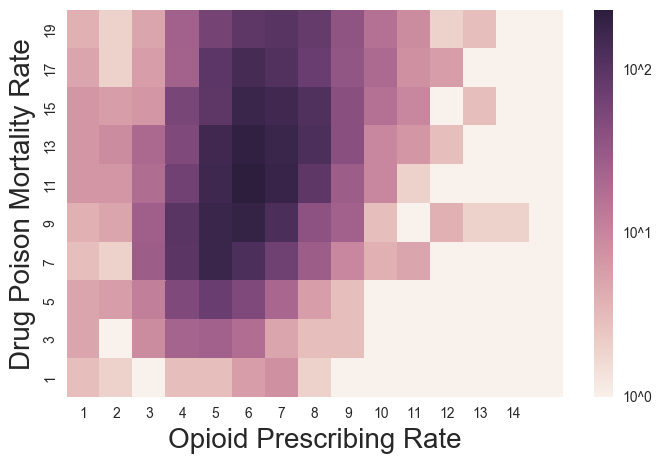

In [82]:
h2d, xe, ye = np.histogram2d(df['Opioid Prescribing Rate'], df['Death Rate Category Median'],
                             bins=[xrange(0,16,1), xrange(0,22,2)])
h2d = h2d.transpose()
#ax = sns.heatmap(h2d)
#ax.invert_yaxis()
h2d = np.log10(h2d)
h2d[h2d == -np.inf] = 0

fig = plt.subplots(figsize=(8,5))
ax = sns.heatmap(h2d, xticklabels=range(1,15,1), yticklabels=range(1,21,2))
ax.invert_yaxis()
ax.set_xlabel('Opioid Prescribing Rate')
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel('Drug Poison Mortality Rate')
ax.yaxis.label.set_fontsize(20)
cbar = ax.collections[0].colorbar
maxval = np.max(h2d)
cbar.set_ticks([x for x in np.arange(0,maxval, 1)])
cbar.set_ticklabels(['10^{0}'.format(int(x)) for x in np.arange(0,maxval, 1)])
plt.savefig('EDA_opioidrate.png')

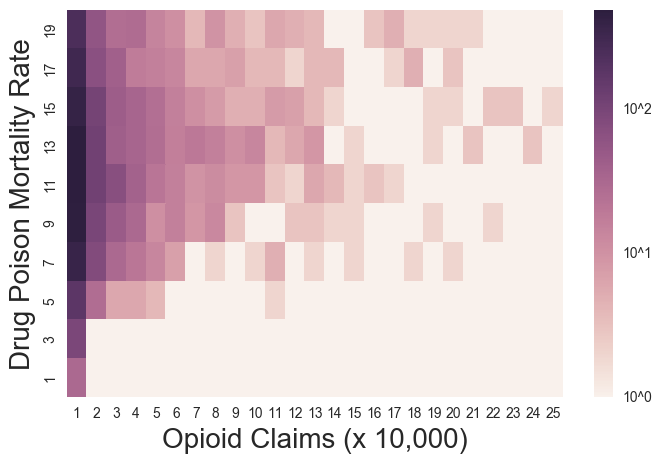

In [86]:
h2d, xe, ye = np.histogram2d(df['Opioid Claims'], df['Death Rate Category Median'],
                             bins=[xrange(0,260000,10000), xrange(0,22,2)])
h2d = h2d.transpose()
#ax = sns.heatmap(h2d)
#ax.invert_yaxis()
h2d = np.log10(h2d)
h2d[h2d == -np.inf] = 0

fig = plt.subplots(figsize=(8,5))
ax = sns.heatmap(h2d, xticklabels=range(1,26,1), yticklabels=range(1,21,2))
ax.invert_yaxis()
ax.set_xlabel('Opioid Claims (x 10,000)')
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel('Drug Poison Mortality Rate')
ax.yaxis.label.set_fontsize(20)
cbar = ax.collections[0].colorbar
maxval = np.max(h2d)
cbar.set_ticks([x for x in np.arange(0,maxval, 1)])
cbar.set_ticklabels(['10^{0}'.format(int(x)) for x in np.arange(0,maxval, 1)])
plt.savefig('EDA_opioidclaims.png')

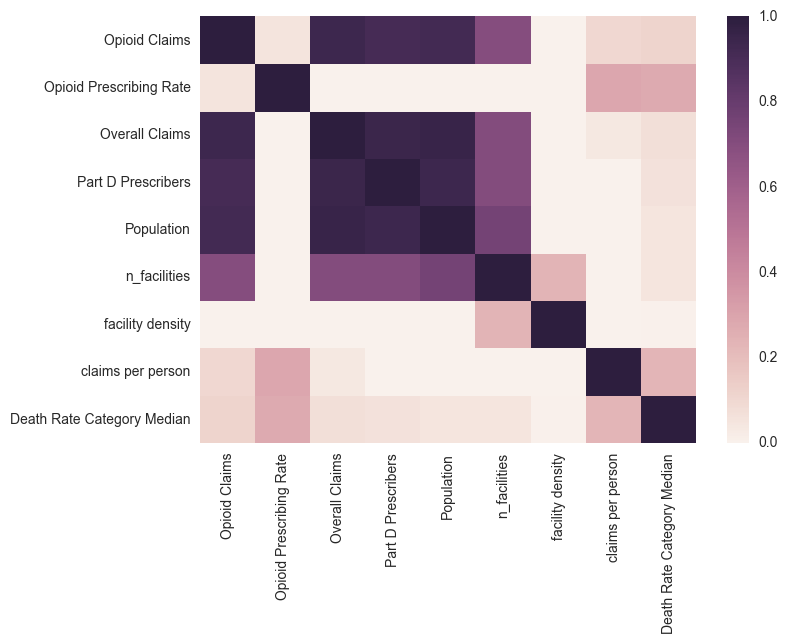

In [95]:
pred_cols = ['Opioid Claims', 'Opioid Prescribing Rate', 'Overall Claims',
             'Part D Prescribers', 'Population',
             'n_facilities', 'facility density', 'claims per person',
             'Death Rate Category Median']
df2 = df.copy()
df2['facility density'] = df2['n_facilities'].values/df2['Population'].values
df2['claims per person'] = df2['Opioid Claims'].values/df2['Population'].values
sns.heatmap(df2[pred_cols].corr(), vmin=0)